In [4]:
import os
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import glob
import torch

from transformers import AutoProcessor, MusicgenForConditionalGeneration

np.random.seed(1)

BASE_DIR = r"D:\jupyter_notebook\musicgen\musicgen-experiment"
DATA_ROOT = os.path.join(BASE_DIR, "data", "exp1")
RESULT_ROOT = os.path.join(BASE_DIR, "results")

os.makedirs(os.path.join(DATA_ROOT, "clip1", "plain"), exist_ok=True)
os.makedirs(os.path.join(DATA_ROOT, "clip1", "structured"), exist_ok=True)
os.makedirs(RESULT_ROOT, exist_ok=True)

C:\Users\Camille\anaconda3\envs\musicgen_clean\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print("PyTorch CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("⚠️ No GPU detected, generation will be slow.")


PyTorch CUDA available: True
Device: NVIDIA GeForce RTX 4060 Laptop GPU


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small").to(device)

sampling_rate = model.config.audio_encoder.sampling_rate
sampling_rate

Using device: cuda


C:\Users\Camille\anaconda3\envs\musicgen_clean\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Camille\.cache\huggingface\hub\models--facebook--musicgen-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to

32000

In [7]:
CLIPS = {
    "clip1": {
        "target_bpm": 120,
        "n_sections": 2
    }
}

N_SAMPLES_PER_CONDITION = 3
MAX_NEW_TOKENS = 1500

base_text = "slow lofi piano track with soft drums"


In [8]:
def build_structured_prompt(base_text, bpm, n_sections):
    return (
        f"{base_text} around {bpm} BPM, "
        f"{n_sections} sections of equal length, "
        f"second section slightly more intense"
    )

def generate_samples(clip_id, condition, prompt, n_samples):
    out_folder = os.path.join(DATA_ROOT, clip_id, condition)
    os.makedirs(out_folder, exist_ok=True)

    for i in range(n_samples):
        inputs = processor(text=[prompt], padding=True, return_tensors="pt").to(device)
        audio_values = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS
        )
        
        audio_array = audio_values[0, 0].cpu().numpy()
        fname = os.path.join(out_folder, f"{condition[0]}{i}.wav")
        sf.write(fname, audio_array, samplerate=sampling_rate)
        print("Saved:", fname)

for clip_id, cfg in CLIPS.items():
    bpm = cfg["target_bpm"]

    plain_prompt = base_text
    generate_samples(clip_id, "plain", plain_prompt, N_SAMPLES_PER_CONDITION)

    structured_prompt = build_structured_prompt(base_text, bpm, cfg["n_sections"])
    generate_samples(clip_id, "structured", structured_prompt, N_SAMPLES_PER_CONDITION)


Saved: D:\jupyter_notebook\musicgen\musicgen-experiment\data\exp1\clip1\plain\p0.wav
Saved: D:\jupyter_notebook\musicgen\musicgen-experiment\data\exp1\clip1\plain\p1.wav
Saved: D:\jupyter_notebook\musicgen\musicgen-experiment\data\exp1\clip1\plain\p2.wav
Saved: D:\jupyter_notebook\musicgen\musicgen-experiment\data\exp1\clip1\structured\s0.wav
Saved: D:\jupyter_notebook\musicgen\musicgen-experiment\data\exp1\clip1\structured\s1.wav
Saved: D:\jupyter_notebook\musicgen\musicgen-experiment\data\exp1\clip1\structured\s2.wav


In [9]:
def estimate_bpm(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    return float(tempo)

def energy_curve(audio_path, n_frames=64):
    y, sr = librosa.load(audio_path, sr=None)
    frame_len = len(y) // n_frames
    energies = [
        np.mean(y[i*frame_len:(i+1)*frame_len]**2)
        for i in range(n_frames)
    ]
    energies = np.array(energies)
    if energies.max() > 0:
        energies = energies / energies.max()
    return energies

def tempo_score(bpm_gen, bpm_target, tol=20):
    err = abs(bpm_gen - bpm_target)
    return max(0.0, 1.0 - err / tol)

def section_score(curve, n_sections):
    if len(curve) < n_sections:
        return 0.5
    section_len = len(curve) // n_sections
    pattern = np.concatenate([np.full(section_len, i) for i in range(n_sections)])
    pattern = pattern[:len(curve)]
    pattern = pattern / pattern.max()
    if curve.max() > 0:
        curve = curve / curve.max()
    corr = np.corrcoef(curve, pattern)[0,1]
    return float((corr + 1) / 2)

def final_score(t, s):
    return 0.5*t + 0.5*s


In [10]:
records = []

for clip_id in CLIPS.keys():
    for cond in ["plain", "structured"]:
        folder = os.path.join(DATA_ROOT, clip_id, cond)
        wavs = sorted(glob.glob(os.path.join(folder, "*.wav")))
        
        for path in wavs:
            bpm = estimate_bpm(path)
            curve = energy_curve(path)
            t_s = tempo_score(bpm, CLIPS[clip_id]["target_bpm"])
            s_s = section_score(curve, CLIPS[clip_id]["n_sections"])
            f_s = final_score(t_s, s_s)
            
            records.append({
                "clip": clip_id,
                "condition": cond,
                "file": os.path.basename(path),
                "bpm": bpm,
                "tempo_score": t_s,
                "section_score": s_s,
                "final_score": f_s
            })

df1 = pd.DataFrame(records)
df1


C:\Users\Camille\AppData\Local\Temp\ipykernel_12648\353128459.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(tempo)


clip   condition    file         bpm  tempo_score  section_score  \
0  clip1       plain  p0.wav   37.500000     0.000000       0.521473   
1  clip1       plain  p1.wav   79.787234     0.000000       0.496553   
2  clip1       plain  p2.wav   79.787234     0.000000       0.699238   
3  clip1  structured  s0.wav  120.967742     0.951613       0.361711   
4  clip1  structured  s1.wav   79.787234     0.000000       0.618109   
5  clip1  structured  s2.wav  120.967742     0.951613       0.542820   

   final_score  
0     0.260737  
1     0.248276  
2     0.349619  
3     0.656662  
4     0.309054  
5     0.747216

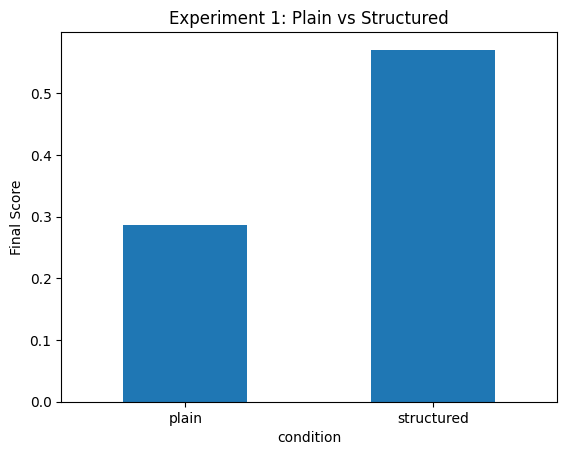

In [11]:
mean_scores = df1.groupby("condition")["final_score"].mean()
mean_scores.plot(kind="bar")
plt.title("Experiment 1: Plain vs Structured")
plt.ylabel("Final Score")
plt.xticks(rotation=0)
plt.show()


In [12]:
df_struct = df1[df1["condition"]=="structured"]
scores = df_struct["final_score"].values

random_score = float(np.random.choice(scores))
best_score = float(scores.max())

pd.DataFrame([{
    "random_score": random_score,
    "best_score": best_score
}])


random_score  best_score
0      0.309054    0.747216

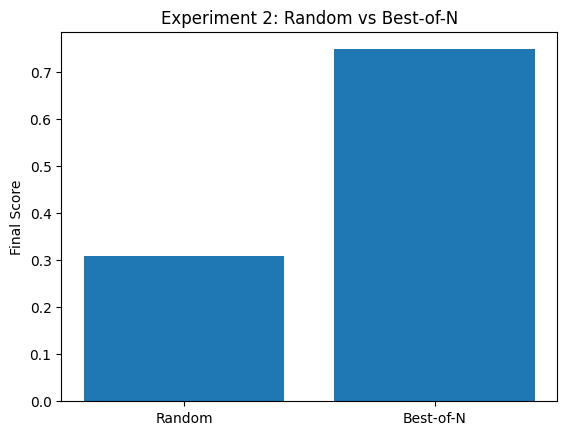

In [13]:
plt.bar(["Random","Best-of-N"], [random_score, best_score])
plt.title("Experiment 2: Random vs Best-of-N")
plt.ylabel("Final Score")
plt.show()

In [14]:
import IPython.display as ipd
ipd.Audio(os.path.join(DATA_ROOT, "clip1", "plain", "p0.wav"))

In [15]:
ipd.Audio(os.path.join(DATA_ROOT, "clip1", "structured", "s0.wav"))